In [298]:
import numpy as np
import underworld as uw
from underworld import function as fn
import glucifer
from easydict import EasyDict as edict
import networkx as nx
import operator


In [323]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1"), 
                                 elementRes  = (96, 48), 
                                 minCoord    = (-1.0, 0.0), 
                                 maxCoord    = (1.0, 1.0) )


temperatureField = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )
velocityField = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=2 )


In [324]:
class szModel(object):
    def __init__(self, mesh,tField, vField):
        self.mesh = mesh
        self.temperatureField = tField
        self.velocityField = vField
        #basic coordinate fns
        coordinate = fn.input()
        self.xFn = coordinate[0]  #a function providing the x-coordinate
        self.yFn = coordinate[1]
        self.depthFn = self.mesh.maxCoord[1] - coordinate[1] #a function providing the depth
        #basic mesh variables
        


In [325]:
szm = szModel(mesh,  temperatureField, velocityField)
szm.mesh.minCoord[0]

-1.0

## tectModel based on networkx

In [400]:
class TectModel(nx.DiGraph):
    
    
    def __init__(self, szModel, starttime, endtime, dt):
        
        ########Trying various ways to init the parent class
        #super(nx.DiGraph, self).__init__(*args)
        #super().__init__(*args) 
        nx.DiGraph.__init__(self) 
        ################################
        
        self.szModel = szModel 
        self.times = np.arange(starttime, endtime, dt)
        #self.add_node('times', times=self.times)
        self.plateIdUsedList = []
        self.plateIdDefaultList = list(np.arange(1, 101))
    
    def add_plate(self, ID = False, velocities = []):
        if type(velocities) == int or type(velocities) == float:
            vels = np.ones(len(self.times ))*velocities
        elif len(velocities) == len(self.times ):
            vels = velocities
        elif len(velocities) != len(self.times ):
            raise ValueError("velocities must be a single float/int or list/array of length self.times ")
        
        #pid = self.plateNames.pop(0)
        #self.add_node(pid, velocities= vels)
        
        if not ID:
            ID = self.plateIdDefaultList[0]
        
        if ID not in self.plateIdUsedList:
            self.add_node(ID, velocities= vels)
            self.plateIdUsedList.append(ID)
            self.plateIdDefaultList.remove(ID)
        else:
            raise ValueError("plate ID already assigned")
            
    def connected_plates(self, plateId):
        return (list(set([x for x in nx.all_neighbors(self, plateId)])))
    
    def is_subducting_plate(self, plateId):
        pass
    
    def has_self_loop(self, plateId):
        pass

        

        
    def add_subzone(self, subPlate, upperPlate, loc, subPlateInitAge=0.0, upperPlateInitAge=0.0):
        
        #check whether the plate boundary can be simply inserted
        if len(self.connected_plates(subPlate)) <=2 and len(self.connected_plates(upperPlate)) <=2 : 

            self.add_edge(subPlate, upperPlate, 
                          loc= loc,
                          ages = [subPlateInitAge, upperPlateInitAge])
        else:
            print('plate already has 2 boundaries. Wait for plate transfer to be implemented')
        
    def add_ridge(self, plate1, plate2, loc, initAge=0.0):
        
        #check whether the plate boundary can be simply inserted
        if len(self.connected_plates(plate1)) <=2 and len(self.connected_plates(plate2)) <=2 : 
        
            self.add_edge(plate1, plate2, loc= loc, ages = initAge)
            self.add_edge(plate2, plate1, loc= loc, ages = initAge)
        else:
            print('plate already has 2 boundaries. Wait for plate transfer to be implemented')
    
    def plate_xFn(self, plateID):
        if len(self.connected_plates(plateID)) == 2:
            pass  
        else:
            print('plate does not have 2 boundaries. Cannot define extent.')
        
    
    def get_boundaries(self, plateId):
        
        """
        Probably a much simpler way of doing this. 
        Need to work arund the complexities of the directed graph
        """
        
        if len(self.connected_plates(plateId)) == 2:
        
            cps = self.connected_plates(plateId )
            pair1 = (plateId , cps[0])
            if pair1 in self.edges(plateId):
                loc1 = self[plateId][cps[0]]['loc']
            elif pair1[::-1] in self.edges(cps[0]):
                loc1 = self[cps[0]][plateId]['loc']

            pair2 = (plateId , cps[1])
            if pair2 in self.edges(plateId):
                loc2 = self[plateId][cps[1]]['loc']
            elif pair2[::-1] in self.edges(cps[1]):
                loc2 = self[cps[1]][plateId]['loc']
                
            return [loc1, loc2]
                
        else:
            print('plate does not have 2 boundaries. Cannot define extent.')
            return []
        
        
    def plate_id_fn(self, boundtol=1e-5):

        condList = []
        for n in self.nodes():
            bounds  = np.sort(self.get_boundaries(n))

            edgetol = 1e-4
            if fn.math.abs(bounds[0] - self.szModel.mesh.minCoord[0]) < edgetol:
                lb = bounds[0] - edgetol
            else:
                lb = bounds[0]

            if fn.math.abs(bounds[1] - self.szModel.mesh.maxCoord[0]) > edgetol:
                ub = bounds[1] + edgetol
            else:
                ub = bounds[1]

            cond = operator.and_(self.szModel.xFn >= lb, self.szModel.xFn < ub)
            condList.append((cond, n))
        condList.append((True, -99))

        idFn = fn.branching.conditional( condList)
        return idFn
    
    
    #def boundary_rFn(self, plate1, plate2):
    # 
    #    pass
        


In [401]:
#Little toy model, 3 plates
############################
#-1        0.0  0.5    1.0
######1##### ###2###  ##3##
            #
             #
###########################

tg = TectModel(szm, 0, 20, 1)

tg.add_plate(1, velocities = 1)
tg.add_plate(velocities = -1)
tg.add_plate( velocities = 0)
        
tg.add_ridge(1, 1, -1.0)
tg.add_subzone(1, 2, 0.0)
tg.add_ridge(2, 3, 0.5)
tg.add_ridge(3, 3, 1.0)

In [402]:
for n in tg.nodes():
    print(tg.get_boundaries(n))

[-1.0, 0.0]
[0.0, 0.5]
[0.5, 1.0]


In [403]:
pIdFn = tg.plate_id_fn()



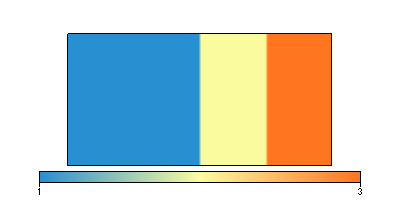

In [406]:
fig = glucifer.Figure(figsize=(400, 200))
fig.append( glucifer.objects.Surface(szm.mesh, pIdFn ))
fig.show()

In [398]:
pId = 2



bounds  = np.sort(tg.get_boundaries(pId))

cond = operator.and_(szm.xFn >= bounds[0], szm.xFn <= bounds[1])
#cond =  szm.xFn > bounds[0]

plate_fn = fn.branching.conditional(  ( (cond,  1.),
                                              (        True, 0.)   ) )

dist = 0.061
cond1 = operator.or_(  fn.math.abs(bounds[0] - szm.xFn) <= dist, fn.math.abs(bounds[1] - szm.xFn) <= dist)

ridgeFn = fn.branching.conditional(  ( (cond1,  1.),
                                              (        True, 0.)   ) )

In [391]:
condList = []
for n in tg.nodes():
    bounds  = np.sort(tg.get_boundaries(n))
    
    edgetol = 1e-4
    if fn.math.abs(bounds[0] - szm.mesh.minCoord[0]) < edgetol:
        lb = bounds[0] - edgetol
    else:
        lb = bounds[0]

    if fn.math.abs(bounds[1] - szm.mesh.maxCoord[0]) > edgetol:
        ub = bounds[1] + edgetol
    else:
        ub = bounds[1]
    
    cond = operator.and_(szm.xFn >= lb, szm.xFn < ub)
    condList.append((cond, n))
condList.append((True, -99))

testFn = fn.branching.conditional( condList)

In [361]:
##test a mapping dictionary

testFn = fn.branching.conditional(  ( (szm.xFn > 0.5,  2),
                                              (        True, 1)   ) )

fn1 = fn.misc.constant(1.)
fn2 = fn.misc.constant(-1.)


map_dict = { 1:fn1,
              2:fn2}
# create function
fn_map = fn.branching.map( fn_key = testFn , 
                          mapping = map_dict )

In [251]:
def get_plate_bounds(tg, plateId):
    tg
    

In [258]:
plateId = 3

  

In [259]:
loc1, loc2
        

(0.5, 1.0)

In [242]:
loc1

0.0

In [127]:
#tg.out_edges(1), tg.in_edges(1),  
#tg.out_edges(2), tg.in_edges(2)

tg.out_edges(1), tg.in_edges(1)

([(1, 1), (1, 2)], [(1, 1)])

In [68]:
#tg.edge['A']['B']['loc']

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy
/usr/local/lib/python2.7/dist-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/usr/local/lib/python2.7/dist-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/usr/local/lib/python2.7/dist-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axe

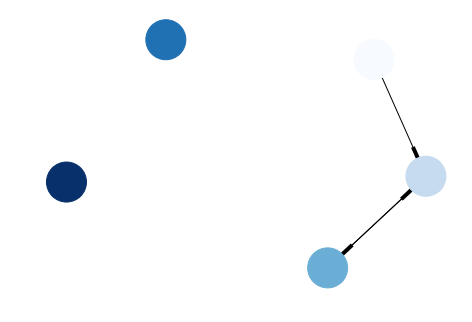

In [69]:
import pylab as plt
%pylab inline
nx.draw(tg,  node_size=1600, cmap=plt.cm.Blues,
        node_color=range(len(tg)),
        prog='dot')
plt.show()

## To do

* decide on what to do about `shadow plates'

* Plate velocity convention (no vels)
    * could be NaN
    
* Age model

## Scratch

In [30]:
G=nx.DiGraph()

In [31]:
G.add_node(1)
G.add_node(2)

In [32]:
G.add_edge(1,2)

G.add_edge(1,1)

In [33]:
G[1], G[2]

({1: {}, 2: {}}, {})

In [34]:
#G.add_edge(1, 'hey')

In [35]:
G.edges()

[(1, 1), (1, 2)]

In [36]:
G.nodes()

[1, 2]

In [37]:
print(G.nodes_with_selfloops())


[1]
